In [1]:
import numpy as np
import scipy as sc
from scipy.io import wavfile
import matplotlib.pyplot as plt
import sounddevice as sd
import IPython.display as ipd

In [2]:
Fs, audio_dat = wavfile.read('data/MS-SNSD/clean_test/clnsp3.wav')
audio_dat = audio_dat/np.max(audio_dat)
Fs = 16e3
time = np.linspace(0, len(audio_dat)/Fs, len(audio_dat))

clean_speech_var = np.linalg.norm(audio_dat - np.mean(audio_dat))**2
ipd.Audio(audio_dat, rate = Fs)

Text(0, 0.5, 'Bits')

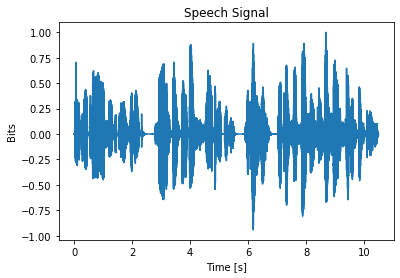

In [3]:
plt.figure(1)
plt.plot(time, audio_dat)
plt.title('Speech Signal')
plt.xlabel('Time [s]')
plt.ylabel('Bits')

## Four Element Microphone Array Locations

[-4, 4, 0, 4]

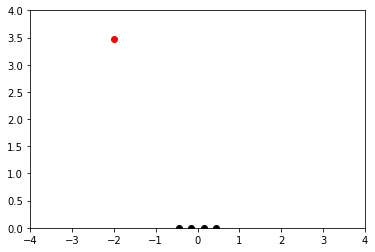

In [4]:
# Best combination - (d, broadside_angle)
# (0.3, 30), (0.3, -30)

d = 30/100 
N = 4
pn = np.zeros([3, N])
pn[0, 0:N] = (np.linspace(1, N, N) - (N + 1)/2)*d
Rad = 4
broadside_angle = -30

src_loc = np.array([Rad*np.sin(np.deg2rad(broadside_angle)), Rad*np.cos(np.deg2rad(broadside_angle)), 0])

plt.figure()
plt.plot(pn[0, :], pn[1, :], 'ko')
plt.plot(src_loc[0], src_loc[1], 'ro')
plt.axis([-Rad, Rad, 0, Rad])

## Propagate Speech Signal to 4 microphone array

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


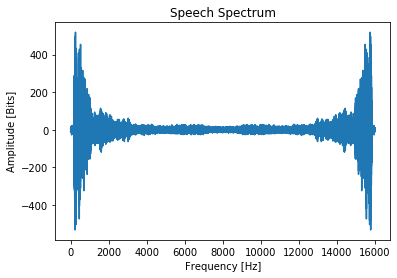

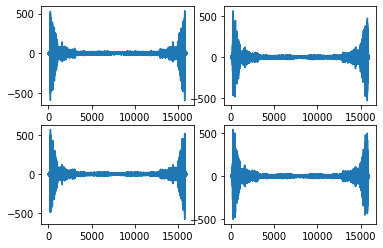

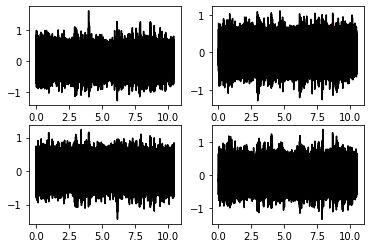

In [5]:
fft_speech = sc.fft(audio_dat)
F = np.linspace(0, Fs, len(audio_dat))

plt.figure(2)
plt.plot(F, fft_speech)
plt.title('Speech Spectrum')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [Bits]')

# Propagating each frequency component to the specific location
sensor_sig_fft = np.zeros([N, len(F)], dtype = np.complex64)
sensor_sig = np.zeros([N, len(F)], dtype = np.complex64)
noise = np.zeros([N, len(F)], dtype = np.float64)
sensor_var = np.zeros(N)
sensor_noise_var = np.zeros(N)
sensor_collected_var = np.zeros(N)
noise_amp = np.zeros(N)
sensor_rms_amp = np.zeros(N)

snr = -5

c = 343 # Speed of sound
kappa_vec = 2*np.pi*F/c # Kappa Vec

for n in range(0, N):
    rn = np.linalg.norm(pn[:, n] - src_loc)
    sensor_sig_fft[n, :] = fft_speech*np.exp(1j*kappa_vec*rn)
    temp = sc.ifft(sensor_sig_fft[n, :])
    sensor_var[n] = np.linalg.norm(temp - np.mean(temp))**2
    sensor_rms_amp[n] = np.sqrt(np.mean(np.abs(temp)**2))
    noise_amp[n] = sensor_rms_amp[n]/(10**(snr/20))
    
    noise[n, :] = noise_amp[n]*np.random.normal(0, 1, len(time))
    
    sensor_sig[n, :] = temp + noise[n, :]
    sensor_noise_var[n] = np.linalg.norm(noise[n, :] - np.mean(noise[n, :]))**2
    sensor_collected_var = np.linalg.norm(sensor_sig[n, :] - np.mean(sensor_sig[n, :]))**2
    temp = np.zeros(shape = time.shape)
    
plt.figure(3)
plt.subplot(2, 2, 1)
plt.plot(F, np.real(sensor_sig_fft[0]))
plt.subplot(2, 2, 2)
plt.plot(F, np.real(sensor_sig_fft[1]))
plt.subplot(2, 2, 3)
plt.plot(F, np.real(sensor_sig_fft[2]))
plt.subplot(2, 2, 4)
plt.plot(F, np.real(sensor_sig_fft[3]))

plt.figure(4)
plt.subplot(2, 2, 1)
plt.plot(time, audio_dat, 'r')
plt.plot(time, np.real(sensor_sig[0]), 'k')

plt.subplot(2, 2, 2)
plt.plot(time, audio_dat, 'r')
plt.plot(time, np.real(sensor_sig[1]), 'k')

plt.subplot(2, 2, 3)
plt.plot(time, audio_dat, 'r')
plt.plot(time, np.real(sensor_sig[2]), 'k')

plt.subplot(2, 2, 4)
plt.plot(time, audio_dat, 'r')
plt.plot(time, np.real(sensor_sig[3]), 'k')

In [6]:
computed_SNR = 10*np.log10(sensor_var/sensor_noise_var)
print(computed_SNR)
print(noise_amp)
print(sensor_rms_amp)

[-5.02883768 -4.99025001 -5.00135219 -5.01978788]
[0.22103135 0.22103135 0.22103133 0.22103134]
[0.12429506 0.12429506 0.12429505 0.12429506]


### Mic 1 Audio Playback

In [7]:
ipd.Audio(np.real(sensor_sig[0]), rate = Fs, normalize=True)

### Mic 2 Audio Playback

In [8]:
ipd.Audio(np.real(sensor_sig[1]), rate = Fs, normalize=True)

### Mic 3 Audio Playback

In [9]:
ipd.Audio(np.real(sensor_sig[2]), rate = Fs, normalize=True)

### Mic 4 Audio Playback

In [10]:
ipd.Audio(np.real(sensor_sig[3]), rate = Fs, normalize=True)

In [11]:
#look_dir = 90*np.pi/180#
look_dir = np.arctan((src_loc[0])/(src_loc[1]))
print(look_dir, np.rad2deg(look_dir), broadside_angle)

steer_vec = np.zeros(shape = (N, len(F)), dtype = np.complex64)
collected_sig_fft = np.zeros(shape = (N, len(F)), dtype = np.complex64)

for m in range(0, N):
    steer_vec[m, :] = np.exp(-1j*kappa_vec*(np.sin(look_dir))*pn[0, m]) 
    collected_sig_fft[m, :] = sc.fft(sensor_sig[m, :])
    
Rxx = np.matmul(collected_sig_fft, np.transpose(np.conjugate(collected_sig_fft)))/len(F)
E, V = np.linalg.eig(Rxx)
Rxx_new = np.diag(E)

-0.5235987755982987 -29.999999999999993 -30


## Calculation of Filter Weights

In [12]:
Rxx_inv = np.linalg.inv(Rxx_new)
W = np.zeros(shape = (N, len(F)), dtype = np.complex64)
y_fft = np.zeros(shape = F.shape, dtype = np.complex64)

for f in range (0, len(F)):
    alpha = 1/np.matmul(np.matmul(np.conjugate(steer_vec[:, f]), Rxx_inv), steer_vec[:, f])
    W[:, f] = alpha*np.matmul(Rxx_inv, steer_vec[:, f])
    
    y_fft[f] = np.matmul(np.transpose(np.conjugate(W[:, f])), collected_sig_fft[:, f])

## Beamformer output

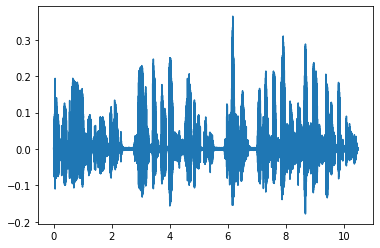

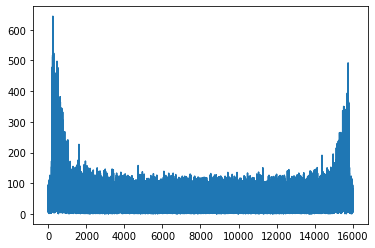

In [13]:
y = sc.ifft(y_fft)

plt.figure(101)
plt.plot(time, np.transpose(y))

plt.figure(102)
plt.plot(F, np.transpose(np.abs(y_fft)))

## Beamformer output playback

In [14]:
ipd.Audio(np.real(y), rate = Fs, normalize=True)

In [15]:
ipd.Audio(np.imag(y), rate = Fs, normalize=True)

## Beampattern for the computed array weights

In [16]:
Th = np.linspace(-np.pi/2, np.pi/2, 361)
B = np.zeros(shape = (N, N, len(Th)), dtype = np.complex64)

for ind, theta in enumerate(Th):
    manifold_vec = np.zeros(shape = (N, len(F)), dtype = np.complex64)
    for m in range(0, N):        
        manifold_vec[m, :] = np.exp(-1j*kappa_vec*(np.sin(theta))*pn[0, m]) 
    
    B[:, :, ind] = np.inner(np.conjugate(W), manifold_vec)

In [18]:
def gccphat(Refsig, Sig, fs, d, interp = 16, c = 343):
    max_tau = None
    sig1 = Refsig
    sig2 = Sig
    m_len = len(sig1) + len(sig2)

    refsig = sc.fft(sig1, n = m_len)
    sig = sc.fft(sig2, n = m_len)
    
    R = sig*np.conj(refsig)

    cc = sc.ifft(R/np.abs(R), n = interp*m_len)
    max_shift = int(interp*m_len/2)

    if max_tau:
        max_shift = np.minimum(int(interp*fs*max_tau), max_shift)
    
    cc = np.concatenate((cc[-max_shift:], cc[:max_shift+1]))

    shift = np.argmax(np.abs(cc)) - max_shift
    tau = shift/float(interp*fs)
    aoa = np.arcsin(c*tau/d) # Angle of arrival
    return aoa, tau, cc

Angle of Arrival:-30.0


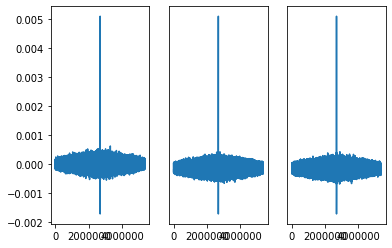

In [19]:
aoa = np.zeros(shape = (N - 1))
tau = np.zeros(shape = (N - 1))
cc = np.zeros(shape = (N - 1, 2*len(time)*16 + 1), dtype = np.complex64)

for m in range(0, N-1):
    aoa[m], tau[m], cc[m, :] = gccphat(sensor_sig[m], sensor_sig[m+1], Fs, d, interp = 16, c = 343)
    
print('Angle of Arrival:' + str(np.round(np.mean(aoa*180/np.pi))))

plt.figure()
for m in range(0, N - 1):
    plt.subplot(1, N-1, m+1)
    plt.plot(cc[m, :])
    
    if (m != 0):
        plt.yticks([])

(-18.0, -42.0)

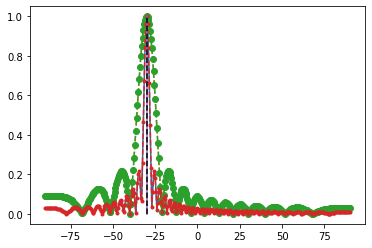

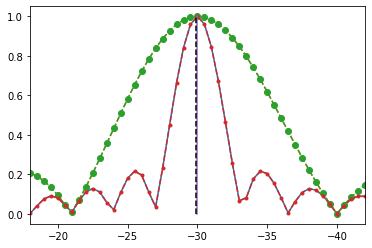

In [20]:
plt.figure()
plt.plot(Th*180/(np.pi), np.abs(B[0, 0, :])/np.max(np.abs(B[0, 0, :])))
plt.plot(Th*180/(np.pi), np.abs(B[1, 1, :])/np.max(np.abs(B[1, 1, :])), '--')
plt.plot(Th*180/(np.pi), np.abs(B[2, 2, :])/np.max(np.abs(B[2, 2, :])), 'o--')
plt.plot(Th*180/(np.pi), np.abs(B[3, 3, :])/np.max(np.abs(B[3, 3, :])), '.--')
plt.plot([look_dir*180/np.pi, look_dir*180/np.pi], [0, 1])
plt.plot([np.mean(aoa*180/np.pi), np.mean(aoa*180/np.pi)], [0, 1], 'k--')


plt.figure()
plt.plot(Th*180/(np.pi), np.abs(B[0, 0, :])/np.max(np.abs(B[0, 0, :])))
plt.plot(Th*180/(np.pi), np.abs(B[1, 1, :])/np.max(np.abs(B[1, 1, :])), '--')
plt.plot(Th*180/(np.pi), np.abs(B[2, 2, :])/np.max(np.abs(B[2, 2, :])), 'o--')
plt.plot(Th*180/(np.pi), np.abs(B[3, 3, :])/np.max(np.abs(B[3, 3, :])), '.--')
plt.plot([look_dir*180/np.pi, look_dir*180/np.pi], [0, 1])
plt.plot([np.mean(aoa*180/np.pi), np.mean(aoa*180/np.pi)], [0, 1], 'k--')
plt.xlim([0.6*broadside_angle, 1.4*broadside_angle])